<a href="https://colab.research.google.com/github/zwimpee/cursivetransformer/blob/main/cursivetransformer_mech_interp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [13]:
!pip install git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python
!pip install transformer_lens
!pip install gradio
!pip install wandb
!pip install einops
!pip install matplotlib
!pip install datasets

# Clone the cursivetransformer repository and install its requirements
!rm -rf cursivetransformer && git clone https://github.com/zwimpee/cursivetransformer.git
!pip install -r cursivetransformer/requirements.txt

  Cloning https://github.com/callummcdougall/CircuitsVis.git to /tmp/pip-req-build-o_95bnbw
  Running command git clone --filter=blob:none --quiet https://github.com/callummcdougall/CircuitsVis.git /tmp/pip-req-build-o_95bnbw
  Resolved https://github.com/callummcdougall/CircuitsVis.git to commit 1e6129d08cae7af9242d9ab5d3ed322dd44b4dd3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Cloning into 'cursivetransformer'...
remote: Enumerating objects: 2609, done.
remote: Counting objects: 100% (750/750), done.
remote: Compressing objects: 100% (256/256), done.
remote: Total 2609 (delta 573), reused 621 (delta 494), pack-reused 1859 (from 1)
Receiving objects: 100% (2609/2609), 40.49 MiB | 14.56 MiB/s, done.
Resolving deltas: 100% (1479/1479), done.
  Cloning https://github.com/callummcdougall/CircuitsVis.git to /tmp/pip-req-build-o_t9lysg
  Running command git clone --filter=blob:none --quiet https://gi

True

In [62]:
import os
import sys; sys.path.append('/content/cursivetransformer');
import copy
import types
from typing import List, Callable, Dict, Optional, Union
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import einops
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import circuitsvis as cv

from IPython.display import display
from jaxtyping import Float, Int

from cursivetransformer.model import get_all_args, get_checkpoint, get_latest_checkpoint_artifact
from cursivetransformer.data import create_datasets, offsets_to_strokes
from cursivetransformer.sample import generate, generate_n_words, plot_strokes
from cursivetransformer.mech_interp import (
    HookedCursiveTransformer,
    HookedCursiveTransformerConfig,
    convert_cursivetransformer_model_config,
    visualize_attention
)

import transformer_lens.utils as utils
from transformer_lens.hook_points import HookPoint

import wandb
wandb.login()

True

In [8]:
args = get_all_args(False)
args.sample_only = True
args.load_from_run_id = '6le6tujz'  # Replace with your actual run ID
args.wandb_entity = 'sam-greydanus'
args.dataset_name = 'bigbank'  # Replace with your dataset name
args.wandb_run_name = 'cursivetransformer_dictionary_learning'

torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

train_dataset, test_dataset = create_datasets(args)

args.block_size = train_dataset.get_stroke_seq_length()
args.context_block_size = train_dataset.get_text_seq_length()
args.vocab_size = train_dataset.get_vocab_size()
args.context_vocab_size = train_dataset.get_char_vocab_size()

Trying to load dataset file from /content/cursivetransformer/data/bigbank.json.zip
Succeeded in loading the bigbank dataset; contains 1900 items.
For a dataset of 1805 examples we can generate 440811596555 combinations of 4 examples.
Generating 497000 4-word examples.
For a dataset of 95 examples we can generate 3183545 combinations of 4 examples.
Generating 3000 4-word examples.
Number of examples in the train dataset: 497000
Number of examples in the test dataset: 3000
Max token sequence length: 1000
Number of unique characters in the ascii vocabulary: 71
Ascii vocabulary:
	" enaitoshrdx.vpukbgfcymzw1lqj804I92637OTAS5N)EHR"'(BCQLMWYU,ZF!DXV?KPGJ"
Split up the dataset into 497000 training examples and 3000 test examples


In [15]:
cfg = convert_cursivetransformer_model_config(args)
model = HookedCursiveTransformer.from_pretrained("cursivetransformer", cfg)

Loading pretrained model cursivetransformer
Finding latest checkpoint for W&B run id 6le6tujz
  model:best_checkpoint:v70
  model:best_checkpoint:v71
  model:best_checkpoint:v72
  model:best_checkpoint:v73
  model:best_checkpoint:v74
  model:best_checkpoint:v75
  model:best_checkpoint:v76
  model:best_checkpoint:v77
  model:best_checkpoint:v78
  model:best_checkpoint:v79
  model:best_checkpoint:v80
  model:best_checkpoint:v81
  model:best_checkpoint:v82
  model:best_checkpoint:v83
  model:best_checkpoint:v84
  model:best_checkpoint:v85
  model:best_checkpoint:v86
  model:best_checkpoint:v87
  model:best_checkpoint:v88
  model:best_checkpoint:v89
  wandb-history:run-6le6tujz-history:v4
Selected:  model:best_checkpoint:v89


wandb:   1 of 1 files downloaded.  


Successfully loaded pretrained model cursivetransformer


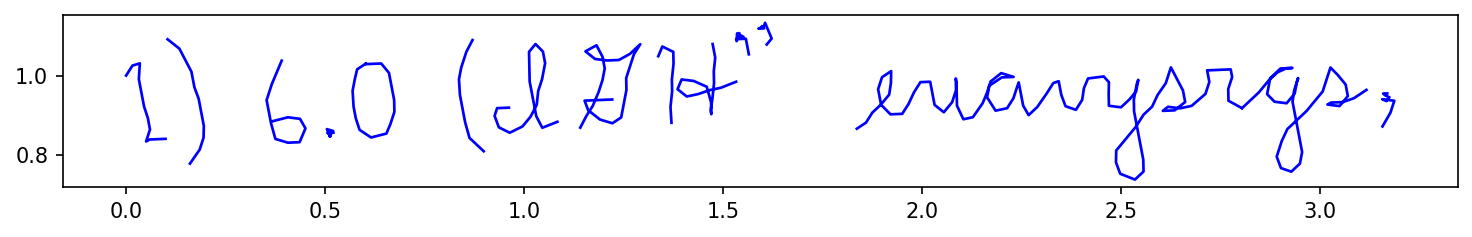

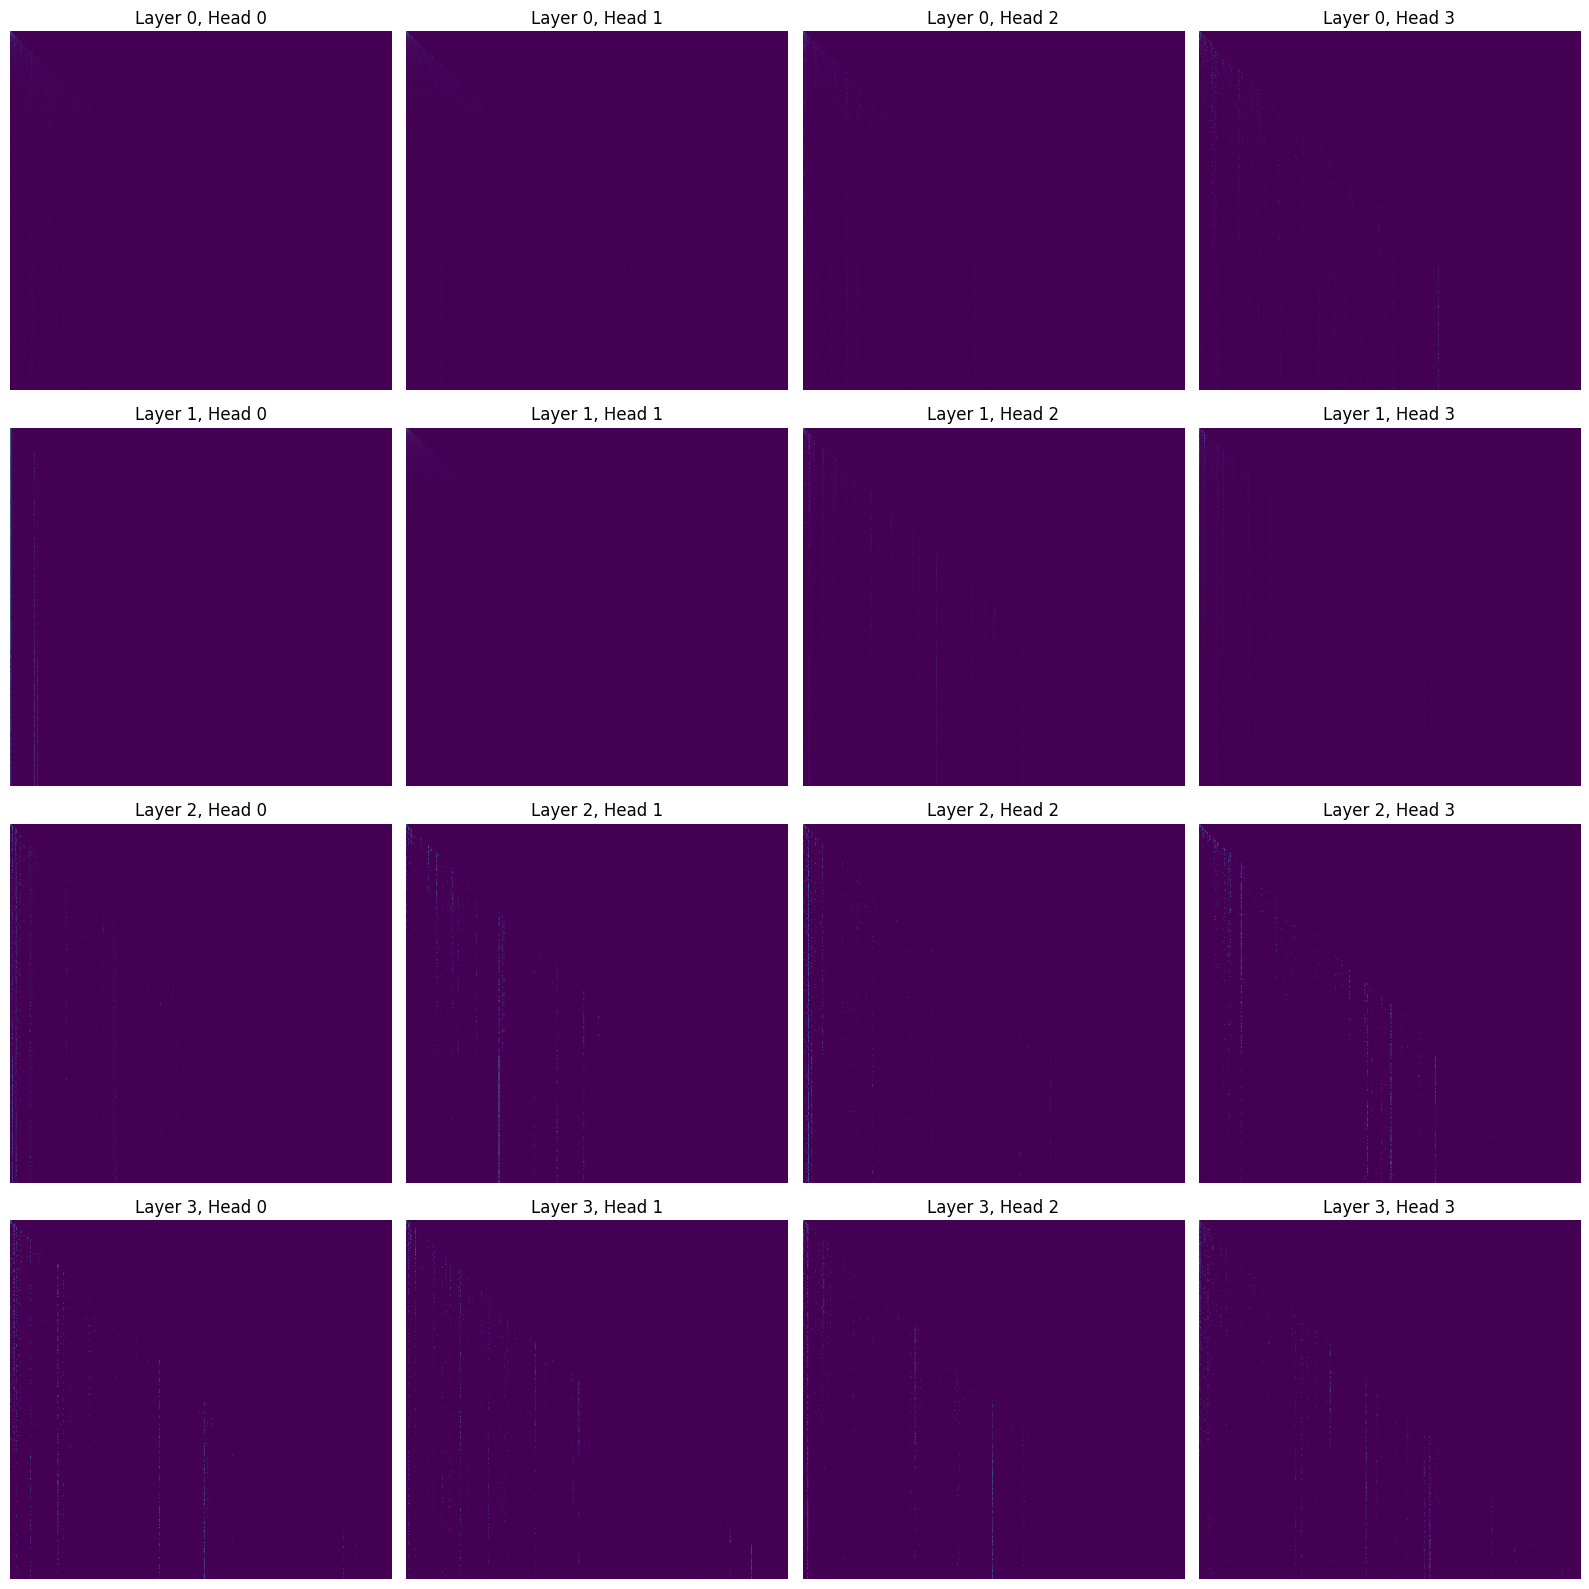

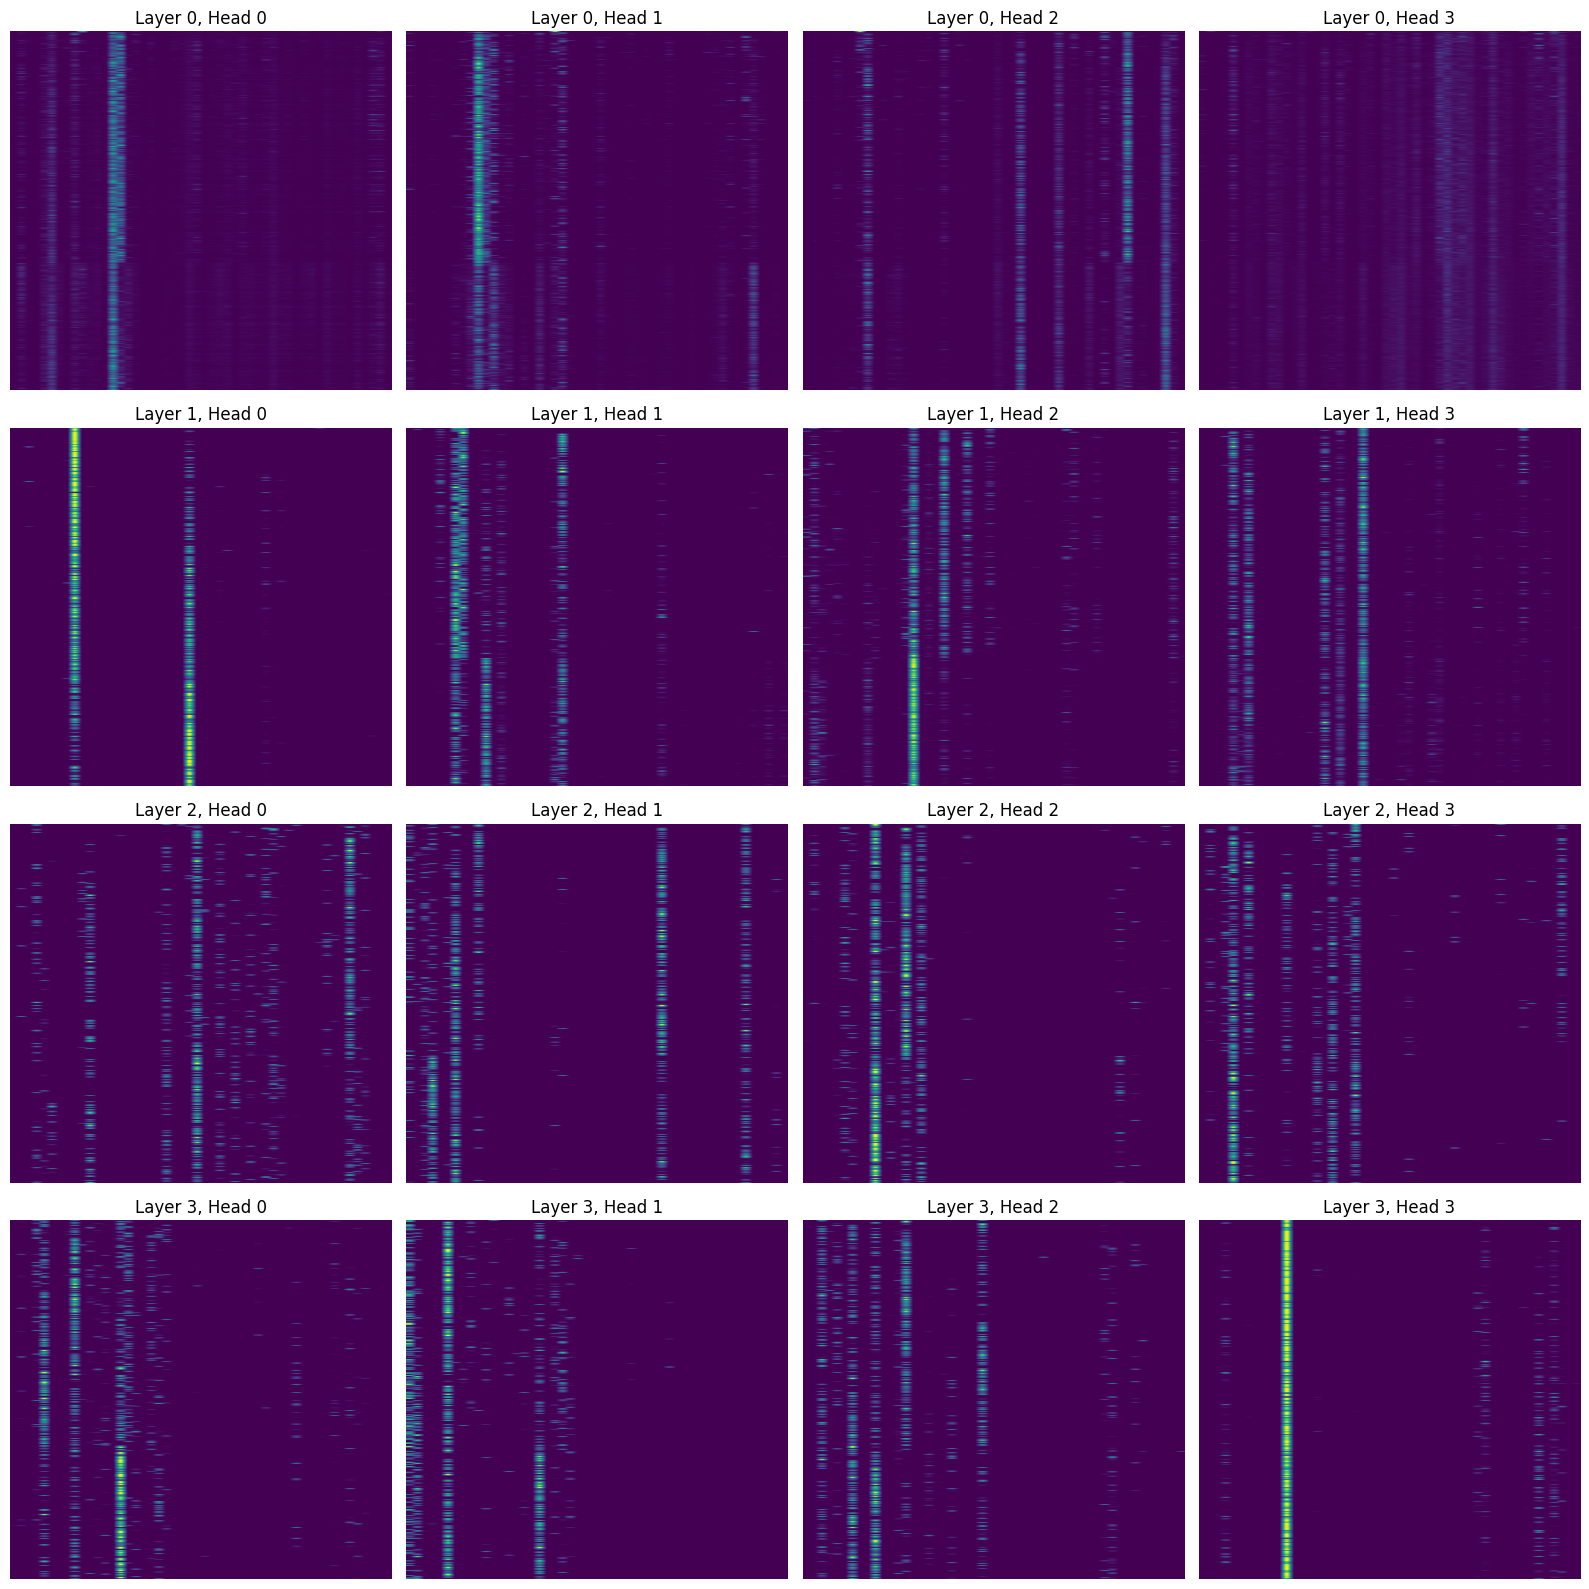

In [21]:
# Add batch dimension to your inputs


# _ = plot_strokes(offsets_to_strokes(test_dataset.decode_stroke(x)),"")
# _ = visualize_attention(model, x, c, layer_range=range(4), head_range=range(4), attn_type='self')
# _ = visualize_attention(model, x, c, layer_range=range(4), head_range=range(4), attn_type='cross')

# Scratch

(<Figure size 1800x300 with 1 Axes>, <Axes: title={'center': '1)'}>)

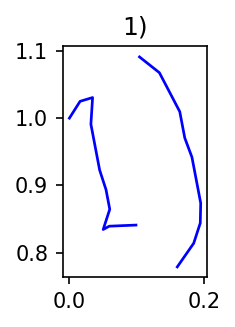

In [51]:
stroke_sequence = x[0][:50]
ascii_sequence = c[0][:2]

plot_strokes(offsets_to_strokes(test_dataset.decode_stroke(stroke_sequence)),test_dataset.decode_text(ascii_sequence))

# Induction Circuit Investigation and Analysis

## 1. Get an example from the dataset and create repeated pattern

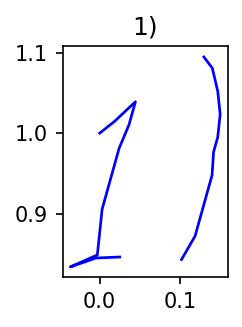

In [96]:
batch_size = 10
index = 0
x, c, y = test_dataset[index]
x = x.unsqueeze(0) # Shape: [1, 1000]
c = c.unsqueeze(0) # Shape: [1, 50]
y = y.unsqueeze(0) # Shape: [1, 1000]

# Select parts of the stroke sequence and ASCII sequence for repeating
stroke_sequence = x[0][:50]  # Truncate stroke sequence to length 50
ascii_sequence = c[0][:2]    # Truncate ASCII sequence to length 2

_ = plot_strokes(offsets_to_strokes(test_dataset.decode_stroke(stroke_sequence)), test_dataset.decode_text(ascii_sequence))

In [95]:
# Create repeated sequences
repeated_stroke_sequence = einops.repeat(stroke_sequence, "seq_len -> (2 seq_len)")
repeated_ascii_sequence = einops.repeat(ascii_sequence, "seq_len -> (2 seq_len)")

print(f'len(repeated_stroke_sequence):{len(repeated_stroke_sequence)}')
print(f'len(repeated_ascii_sequence): {len(repeated_ascii_sequence)}')

len(repeated_stroke_sequence):102
len(repeated_ascii_sequence): 4
len(repeated_tokens):10
len(repeated_context): 10


Clean Predictions: tensor([[300, 432, 339, 447, 226, 150,  76,  76,  76, 110, 100, 232, 412,  76,
         420, 241,  76, 241, 423,  76, 447,  76, 117,  54,  76, 117, 447,  76,
         100, 104, 110,  76,  76,  76, 154, 423, 438, 368, 104, 430, 241, 382,
         384, 384,  76,  73, 101, 188, 447, 361]])
Corrupted Predictions: tensor([[445, 110, 169, 226, 373, 110, 425, 169, 169, 226, 169, 110, 110, 110,
         110, 169, 110,  46, 110,  13, 110, 110, 110, 436, 423, 110, 373, 150,
         110, 110, 169, 169, 169, 226, 110, 241, 110, 226, 226, 226, 169, 295,
         110, 110, 226, 373, 327, 373, 361, 111]])
Patched Predictions: tensor([[300, 432, 339, 447, 226, 150,  76,  76,  76, 110, 100, 232, 412,  76,
         420, 241,  76, 241, 423,  76, 447,  76, 117,  54,  76, 117, 447,  76,
         100, 104, 110,  76,  76,  76, 154, 423, 438, 368, 104, 430, 241, 382,
         384, 384,  76,  73, 101, 188, 447, 361]])


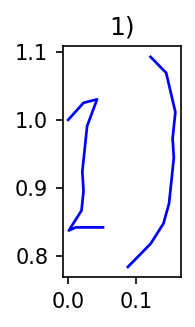

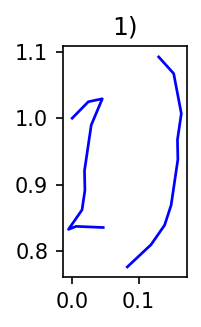

In [61]:
# Call the model with cross-attention
repeated_logits = model(repeated_tokens, repeated_context)

# Compute per-token losses using the updated loss_fn
correct_log_probs = model.loss_fn(repeated_logits, repeated_tokens, per_token=True)

# Compute loss by position
detached_loss_by_position = correct_log_probs.detach()  # Detach from computation graph
loss_by_position = einops.reduce(detached_loss_by_position, "batch position -> position", "mean")

# Plot the loss by position
px.line(y=loss_by_position, labels={"x": "Position", "y": "Loss"}, title="Loss by position on repeated tokens from dataset").show()

# Store induction scores
induction_score_store = torch.zeros((model.cfg.n_layers, model.cfg.n_heads), device=model.cfg.device)

def induction_score_hook(pattern: torch.Tensor, hook: HookPoint):
    induction_stripe = pattern.diagonal(dim1=-2, dim2=-1, offset=1 - stroke_sequence.shape[0])
    induction_score = einops.reduce(induction_stripe, "batch head_index position -> head_index", "mean")
    induction_score_store[hook.layer(), :] = induction_score

# Updated hook filter for both self-attention and cross-attention patterns
pattern_hook_names_filter = lambda name: name.endswith("attn.hook_pattern") or name.endswith("cross_attn.hook_pattern")

# Run with hooks to collect induction scores
_ = model.run_with_hooks(
    repeated_tokens,
    repeated_context,
    fwd_hooks=[(
        pattern_hook_names_filter,
        induction_score_hook
    )]
)

# Visualize induction score by head
px.imshow(induction_score_store.detach().cpu(), labels={"x": "Head", "y": "Layer"}, title="Induction Score by Head").show()

# Visualization of Attention Pattern - Updated for Cross-Attention
def visualize_pattern_hook(pattern: torch.Tensor, hook: HookPoint):
    display(
        cv.attention.attention_patterns(
            tokens=repeated_tokens,
            attention=pattern[0, induction_head_index, :, :][None, :, :] # Add a dummy axis, as CircuitsVis expects 3D patterns.
        )
    )

induction_head_layer = 3
induction_head_index = 1
model.run_with_hooks(
    repeated_tokens,
    repeated_context,
    fwd_hooks=[(
        'blocks.{}.cross_attn.hook_pattern'.format(induction_head_layer),
        visualize_pattern_hook
    )]
)

# Activation Patching

In [ ]:
# Activation Patching - Updated for Cross-Attention
def activation_patching(
    model: HookedCursiveTransformer,
    x_clean: torch.Tensor,
    c_clean: torch.Tensor,
    x_corrupted: torch.Tensor,
    c_corrupted: torch.Tensor,
    patching_nodes: List[str],
    patch_positions: Optional[torch.Tensor] = None,
):
    _, cache_corrupted = model.run_with_cache(x_corrupted, c_corrupted, return_type="both")

    def patching_hook(act, hook):
        act_corrupted = cache_corrupted[hook.name]
        if patch_positions is not None:
            act[:, patch_positions, :] = act_corrupted[:, patch_positions, :]
        else:
            act[:] = act_corrupted
        return act

    hooks = [(node, patching_hook) for node in patching_nodes]
    logits_patched = model.run_with_hooks(x_clean, c_clean, fwd_hooks=hooks, return_type="logits")
    return logits_patched

# Example Activation Patching
x_clean = stroke_sequence.unsqueeze(0)
c_clean = ascii_sequence.unsqueeze(0)

x_corrupted = x_clean.clone()
x_corrupted = (x_corrupted + 1) % model.cfg.d_vocab
c_corrupted = c_clean.clone()

patching_nodes = ['blocks.0.cross_attn.hook_result']
logits_patched = activation_patching(
    model,
    x_clean,
    c_clean,
    x_corrupted,
    c_corrupted,
    patching_nodes,
)

# Get predictions from patched logits
predictions_patched = logits_patched.argmax(dim=-1)

# Run the clean input without patches
logits_clean = model(x_clean, c_clean)
predictions_clean = logits_clean.argmax(dim=-1)

# Run the corrupted input without patches
logits_corrupted = model(x_corrupted, c_corrupted)
predictions_corrupted = logits_corrupted.argmax(dim=-1)

# Compare predictions
print("Clean Predictions:", predictions_clean)
print("Corrupted Predictions:", predictions_corrupted)
print("Patched Predictions:", predictions_patched)

# Visualize the strokes if applicable
_ = plot_strokes(offsets_to_strokes(test_dataset.decode_stroke(stroke_sequence)), test_dataset.decode_text(ascii_sequence))
_ = plot_strokes(offsets_to_strokes(test_dataset.decode_stroke(x_corrupted[0])), test_dataset.decode_text(c_corrupted[0]))